In [1]:
# Importing all the things!
from gaia_tools import query
import matplotlib
#matplotlib.use("AGG") --> for running scripts (then take out '%pylab inline')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from astropy.table import Table #don't think this is actually used anywhere
#import pyexcel
from astropy import units as u
from astropy.coordinates import SkyCoord

import sklearn
from sklearn import cluster
from matplotlib.patches import Circle

from PyPDF2 import PdfFileWriter, PdfFileReader

%pylab inline

import pywt
from galpy.util import bovy_plot

import gaia_tools.load as gload
from astroquery.gaia import Gaia

from astroquery.ned import Ned
from astropy import coordinates

from scipy import stats
from matplotlib import colors, ticker, cm


Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443
Populating the interactive namespace from numpy and matplotlib


In [8]:
# Set up for DBSCANN -> Gaia Query
# Load csv's and convert to Pandas DataFrame, then separate columns into Pandas Series(default) variables to be called later

# This one is of details from GC table online (Harris)
GlobClust_Log_ra_dec = pd.read_csv('~/GlobClust_ra-dec.csv') 
GlobClust_Log_r_t = GlobClust_Log_ra_dec.loc[0:0,"r_t"]      # limiting radius
GlobClust_Log_radec = GlobClust_Log_ra_dec.loc[0:0,"RA":"DEC"] 
GlobClust_Log_ID = GlobClust_Log_ra_dec.loc[0:0,"ID"]
GlobClust_Log_r_c = GlobClust_Log_ra_dec.loc[0:0,"r_c"]      # core radius

# This is from running the Gaia query script
GlobClust_Log_2 = pd.read_csv('~/out_NGC 288_full_15rt_ra_dec.csv') 
GlobClust_Log_pmra = GlobClust_Log_2.loc[:,"pmra"]
GlobClust_Log_pmdec = GlobClust_Log_2.loc[:,"pmdec"]
GlobClust_Log_pmra_error = GlobClust_Log_2.loc[:,"pmra_error"]
GlobClust_Log_pmdec_error = GlobClust_Log_2.loc[:,"pmdec_error"]
GlobClust_Log_ra = GlobClust_Log_2.loc[:,"ra"]
GlobClust_Log_dec = GlobClust_Log_2.loc[:,"dec"]
GlobClust_Log_ra_error = GlobClust_Log_2.loc[:,"ra_error"]
GlobClust_Log_dec_error = GlobClust_Log_2.loc[:,"dec_error"]
GlobClust_Log_g = GlobClust_Log_2.loc[:,"phot_g_mean_mag"]
GlobClust_Log_rp = GlobClust_Log_2.loc[:,"phot_rp_mean_mag"]
GlobClust_Log_bp = GlobClust_Log_2.loc[:,"phot_bp_mean_mag"]
GlobClust_Log_rpbp = GlobClust_Log_bp - GlobClust_Log_rp
#GlobClust_Log_ra_out = GlobClust_Log_2.loc[:,"ra"]
#GlobClust_Log_dec_out = GlobClust_Log_2.loc[:,"dec"]
#GlobClust_Log_pmdec_out = GlobClust_Log_2.loc[:,"pmdec"]
#GlobClust_Log_pmra_out = GlobClust_Log_2.loc[:,"pmra"]
GlobClust_Log_vpu = GlobClust_Log_2.loc[:,"visibility_periods_used"]
GlobClust_Log_aen = GlobClust_Log_2.loc[:,"astrometric_excess_noise"]
GlobClust_Log_parallax = GlobClust_Log_2.loc[:,"parallax"]
GlobClust_Log_parallaxerror = GlobClust_Log_2.loc[:,"parallax_error"]
GlobClust_Log_parallaxe = GlobClust_Log_2.loc[:,"parallax":"parallax_error"]

# Might be helpful if issues arise due to variable type -> changegs DataFrame to numpy array (matrix)
#GlobClust_Log_pmra = GlobClust_Log_pmra.as_matrix()
#GlobClust_Log_pmdec = GlobClust_Log_pmdec.as_matrix()
#GlobClust_Log_ra = GlobClust_Log_ra.as_matrix()
#GlobClust_Log_dec = GlobClust_Log_dec.as_matrix()

# For parallax and parallax fractional error cut
GlobClust_Log_parallaxover = GlobClust_Log_parallaxerror/GlobClust_Log_parallax
parallax_indx = ((1/(GlobClust_Log_parallax)<5.)*(GlobClust_Log_parallaxover<0.10))
parallax_indx = [not i for i in parallax_indx] 

# Transform RA, Dec units to deg
coord_ra_dec = SkyCoord(GlobClust_Log_radec.loc[:,"RA"], GlobClust_Log_radec.loc[:,"DEC"], frame='icrs')

# Define Edges, easier to use for indexing
Clust_Edge = GlobClust_Log_r_c[0]
print(Clust_Edge) # Just nice to see
Tidal_Edge = GlobClust_Log_r_t[0]
print(Tidal_Edge) # Also nice to see

# distance of NGC 288 
d_pc=8900

# Calculating Absolute Magnitude: M=m-5(log(d)-1)
GlobClust_Log_M = GlobClust_Log_g-5*((np.log10(d_pc)) - 1)

# index for circle of stars within cluster core radius -> not really used anywhere
indx = (np.sqrt((np.fabs(GlobClust_Log_ra-coord_ra_dec.ra.deg)**2+np.fabs(GlobClust_Log_dec-coord_ra_dec.dec.deg)**2))\
        <Clust_Edge/60)

# Sometimes nice to print the 2nd DataFrame and see all info
GlobClust_Log_2

/home/kaderali/.local/lib/python3.6/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))

1.35
13.19270248


Unnamed: 0         ra        dec   ra_error  dec_error           l  \
0                0  13.325432 -26.545833   0.331644   0.237084  158.559035   
1                1  13.216021 -24.853873   0.432092   0.351204  131.031316   
2                2  10.978007 -24.156311   2.645801   1.611511   92.804991   
3                3  10.937143 -29.287150   1.050683   0.693727  340.602226   
4                4  12.276909 -25.781061   0.537746   0.436475  101.637459   
5                5  12.092129 -28.699341   0.478994   0.370067  326.097939   
6                6  11.635107 -28.750855   0.066094   0.049423  336.335199   
7                7  15.189868 -25.116791   4.094024   1.847164  169.579706   
8                8  14.134471 -28.189705   0.869072   1.388731  256.452653   
9                9  10.187083 -25.802942  10.822460  18.967922   61.316960   
10              10  10.082050 -28.540633   0.532306   0.375616    2.387548   
11              11  15.434424 -27.196701   0.060655   0.033539  215.230872   
12              12  16.456581 -27.748453   1.612101   1.239477  224.751332   
13              13  13.636018 -25.498912   0.512017   0.523460  146.237857   
14              14  12.700603 -23.926890   0.489253   0.332315  120.333162   
15              15  10.421101 -27.836736   0.691457   0.488981   14.237458   
16              16  11.986221 -25.347881   0.033201   0.023772   98.990257   
17              17  15.867584 -27.747720   0.414406   0.252735  226.685621   
18              18  11.745323 -23.982705   0.487598   0.471030  104.967648   
19              19  13.224393 -26.590072  26.197654   7.006750  154.184439   
20              20  13.506824 -26.933537   1.710747   1.684243  194.420730   
21              21  10.474497 -27.894596   0.391530   0.284809   12.468866   
22              22  14.762923 -23.884259   0.466346   0.262712  151.251770   
23              23  13.032523 -23.924765   0.174893   0.121132  125.760211   
24              24  14.764769 -25.130407   0.150644   0.072275  163.926060   
25              25  11.972324 -24.783370   0.608790   0.533580  103.949122   
26              26  13.765030 -24.545383   2.177859   3.311427  140.644259   
27              27  13.496314 -26.386592   1.543368   1.797506  160.553808   
28              28  13.182522 -26.513934   0.482569   0.406605  148.144924   
29              29  11.797298 -23.734562   3.471282   3.074218  106.917702   
...            ...        ...        ...        ...        ...         ...   
117450      117450  11.461279 -25.930744   0.281344   0.198336   76.366652   
117451      117451  13.185627 -28.571771   0.509573   0.541921  291.710596   
117452      117452  13.154184 -26.609389   0.764117   0.641189  149.868386   
117453      117453  12.744519 -27.278779   0.137700   0.099550  337.091399   
117454      117454  15.000174 -23.918528   0.816364   0.449035  154.441370   
117455      117455  14.150298 -28.605255   0.374449   0.293678  265.542087   
117456      117456  13.563817 -25.789907   0.056286   0.040710  148.317070   
117457      117457  10.460645 -28.306074   0.392480   0.300153    3.363389   
117458      117458  13.219328 -26.579826   0.753922   0.638435  153.357711   
117459      117459  13.903653 -23.337113   0.151435   0.107146  137.147556   
117460      117460  13.339366 -23.792400   0.066218   0.055594  130.436697   
117461      117461  11.937163 -26.431147   0.092733   0.058336   72.975310   
117462      117462  12.336307 -28.236688   0.193291   0.150821  325.494081   
117463      117463  13.187347 -26.564468   0.441206   0.349424  150.429578   
117464      117464  13.133311 -26.498390   0.163029   0.119286  144.200350   
117465      117465  13.269302 -26.544990   2.617828   1.688820  155.110924   
117466      117466  13.199224 -26.606967   3.336417   1.260035  153.182260   
117467      117467  13.196487 -26.615669   1.506885   0.596040  153.398834   
117468      117468  15.483948 -25.900977   0.096749   0.061411  185.931141   
117469      117469  13.501405 

In [9]:
# N-Body Data import and variable saving -> same process as previous cell for data

# Load simulation data
data = np.loadtxt('n288_gaia.dat')
shape(data) # -> number of stars in N-Boday data

# Setup full Pandas DataFrame
data_pd = pd.DataFrame({'id': data[:,0], 'x': data[:,1], 'y': data[:,2], 'z': data[:,3],
                       'vx': data[:,4], 'vy': data[:,5], 'vy': data[:,6], 
                       'ra': data[:,7], 'dec':data[:,8], 'pmra': data[:,9], 'pmdec': data[:,10]})

# Separate into Pandas Series(default) variables for later use
ra_n = data_pd.loc[:,"ra"]
#print(ra_n)
dec_n = data_pd.loc[:,"dec"]
#print(dec_n)
pmra_n = data_pd.loc[:,"pmra"]
#print(pmra_n)
pmdec_n = data_pd.loc[:,"pmdec"]
#print(pmdec_n)

# Indexes: (All centres are shifted to 'match' Gaia data; ra-0.85, dec-0.1)
# circle of stars within core radius
core_indx = (np.sqrt((np.fabs(ra_n.as_matrix()-coord_ra_dec.ra.deg-0.85)**2+\
                       np.fabs(dec_n.as_matrix()-coord_ra_dec.dec.deg-0.1)**2)) <= GlobClust_Log_r_c[0]/60)

# circle of stars within tidal radius
tidal_indx = (np.sqrt((np.fabs(ra_n.as_matrix()-coord_ra_dec.ra.deg-0.85)**2+\
                       np.fabs(dec_n.as_matrix()-coord_ra_dec.dec.deg-0.1)**2)) <= GlobClust_Log_r_t[0]/60)

# circle of stars within Gaia query window (15*r_t) 
tidal_indx_15 = (np.sqrt((np.fabs(ra_n.as_matrix()-coord_ra_dec.ra.deg-0.85)**2+\
                       np.fabs(dec_n.as_matrix()-coord_ra_dec.dec.deg-0.1)**2)) <= GlobClust_Log_r_t[0]/60*15)

# Matching square Gaia query window without stars inside tidal radius
tidal_indx2 = (np.sqrt((np.fabs(ra_n.as_matrix()-coord_ra_dec.ra.deg-0.85)**2+\
                       np.fabs(dec_n.as_matrix()-coord_ra_dec.dec.deg-0.1)**2)) <= GlobClust_Log_r_t[0]/60*15) *\
    (np.sqrt((np.fabs(ra_n.as_matrix()-coord_ra_dec.ra.deg-0.85)**2+\
                       np.fabs(dec_n.as_matrix()-coord_ra_dec.dec.deg-0.1)**2)) > GlobClust_Log_r_t[0]/60)

# Setting up normalized pm values/arrays
pmra_n_norm = pmra_n-pmra_n[core_indx].mean()
pmdec_n_norm = pmdec_n-pmdec_n[core_indx].mean()

/home/kaderali/.local/lib/python3.6/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))

(23540, 4)
(23224, 4)
[ 0 -1 -1 ...  0 -1 -1]
(23224,)
Estimated number of Subgroups: 3


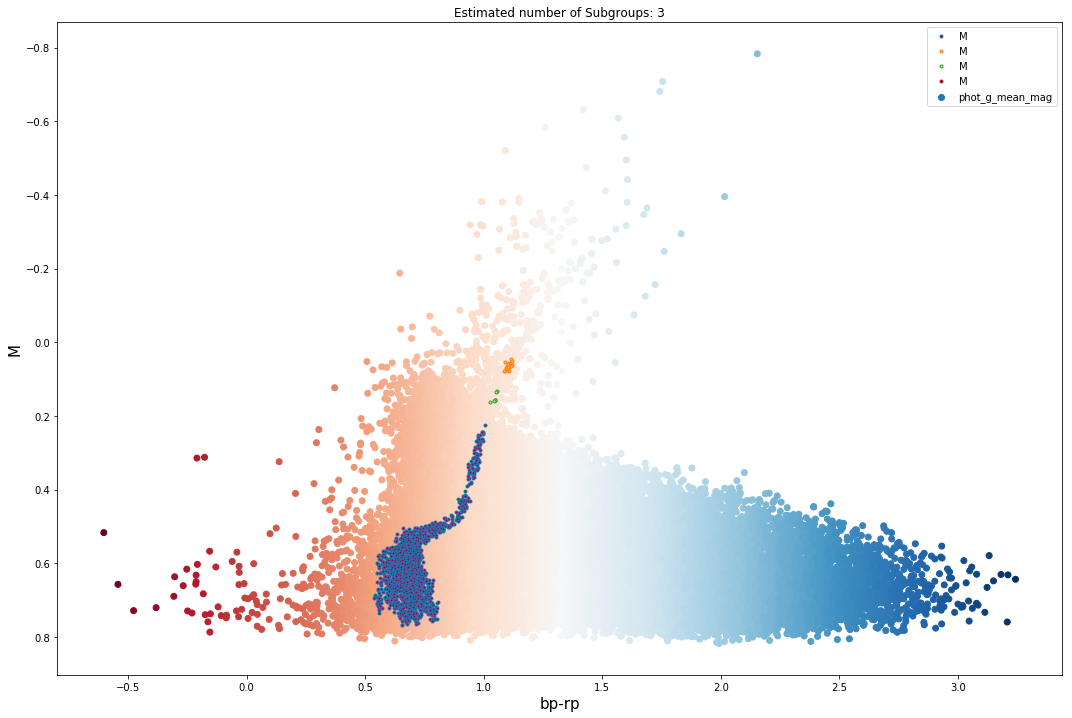

(1711, 1)

 pmra    4.318877
dtype: float64 


 pmdec   -5.691112
dtype: float64


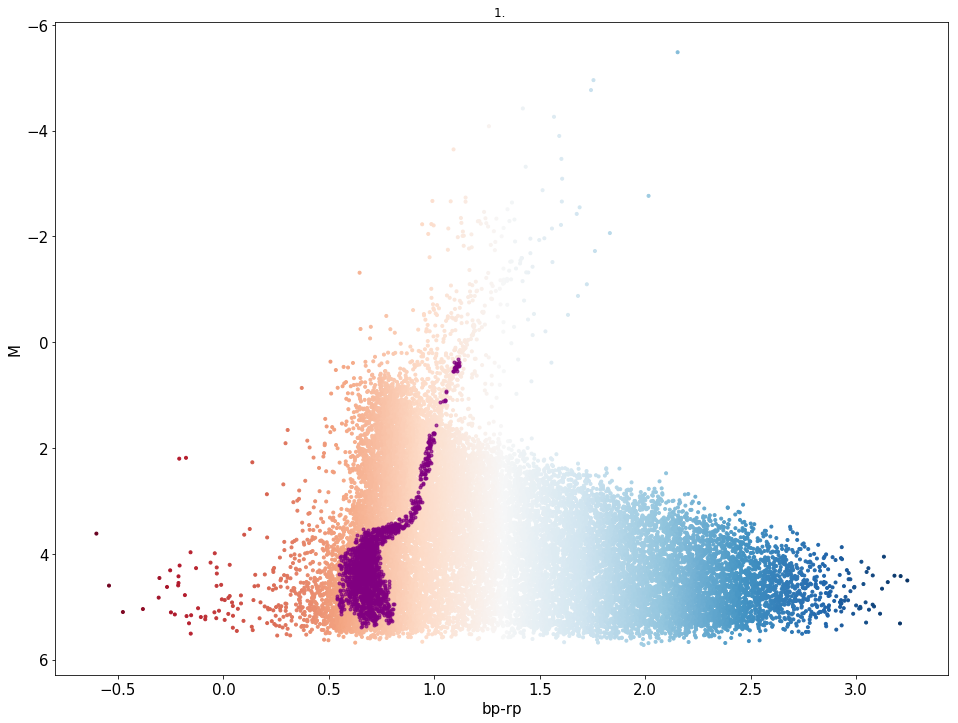

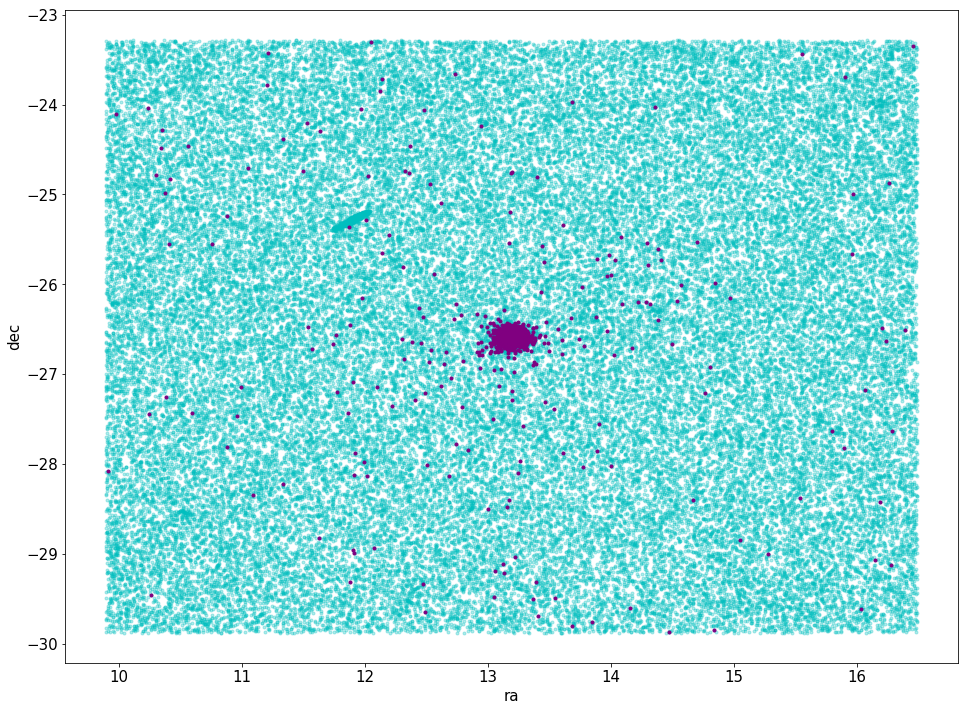

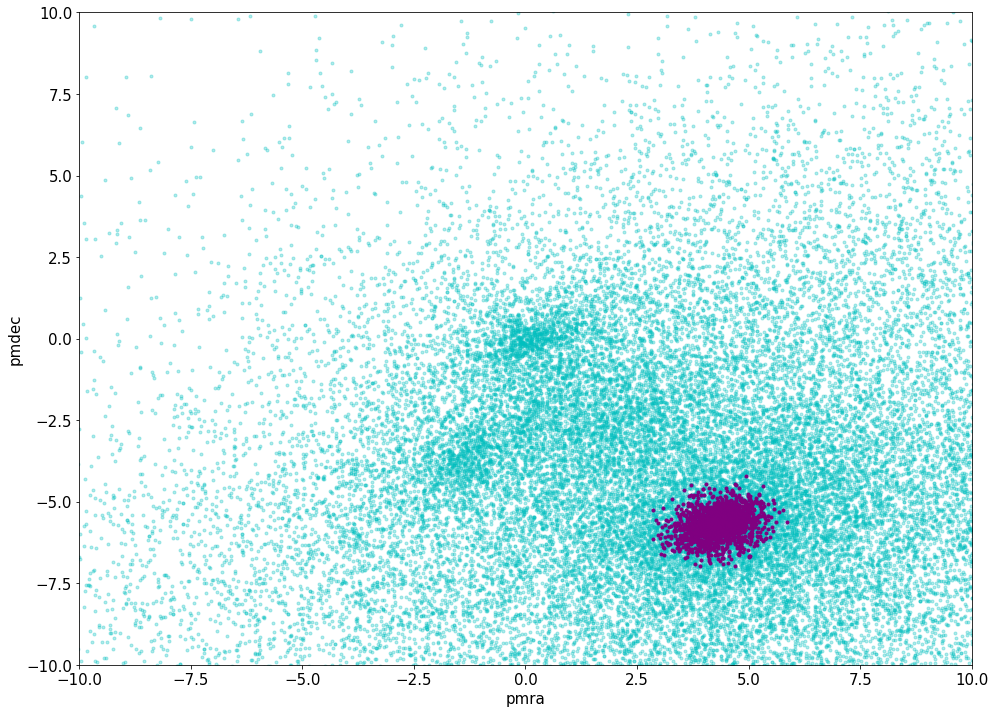

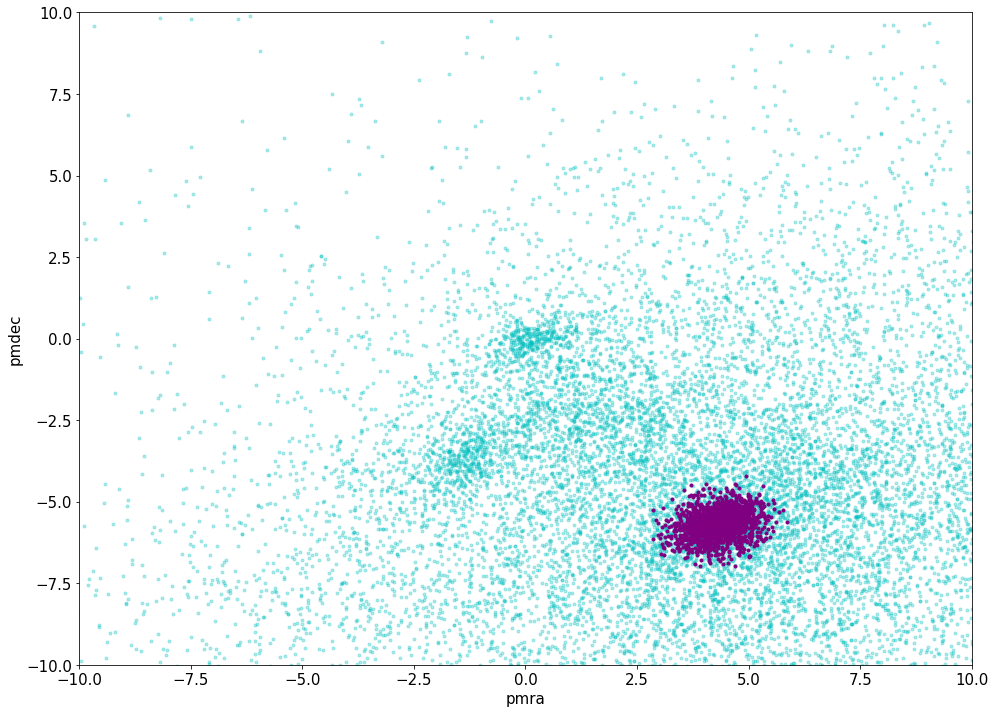

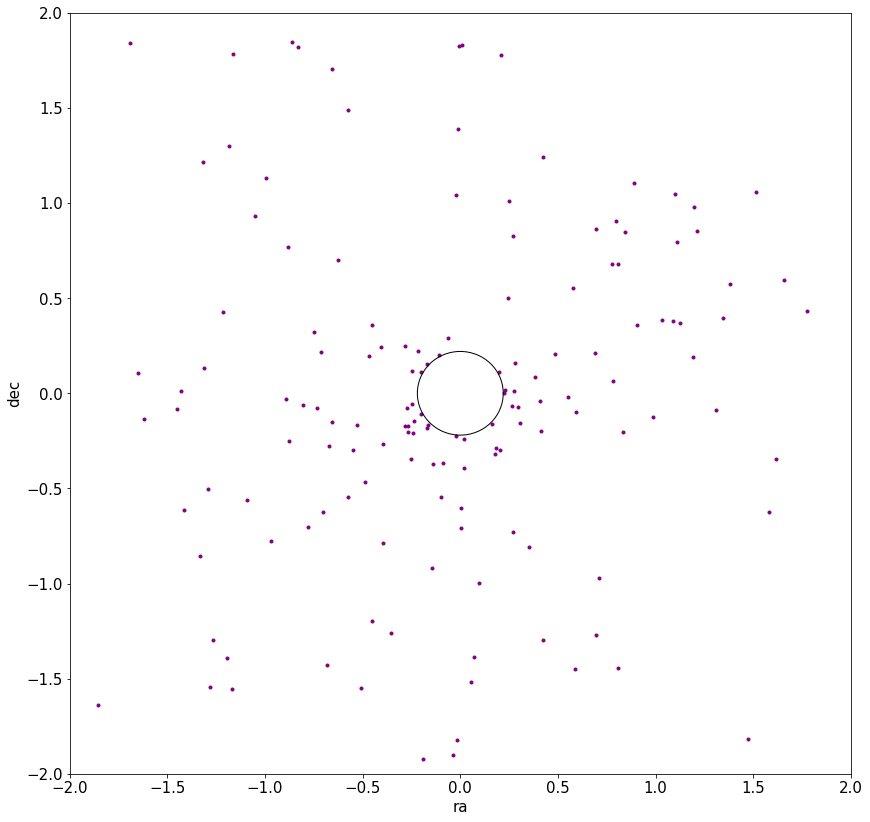

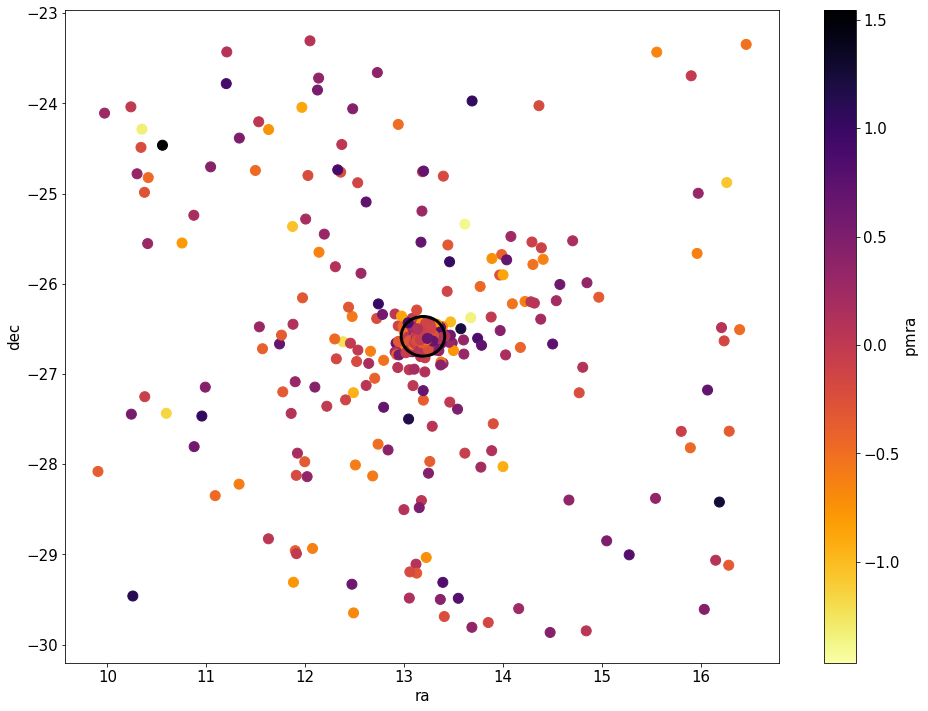

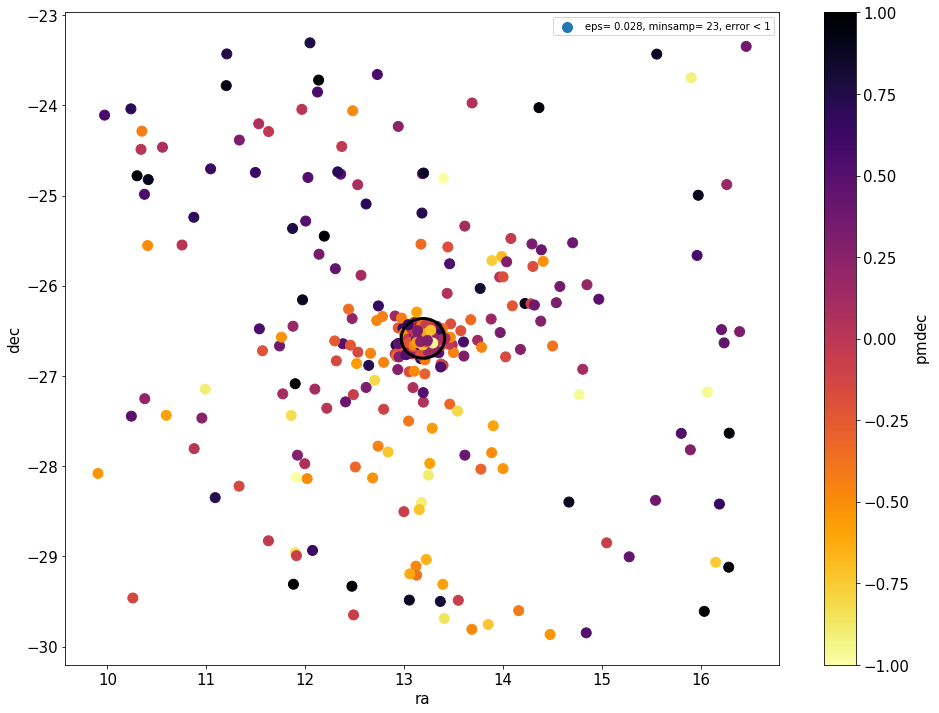

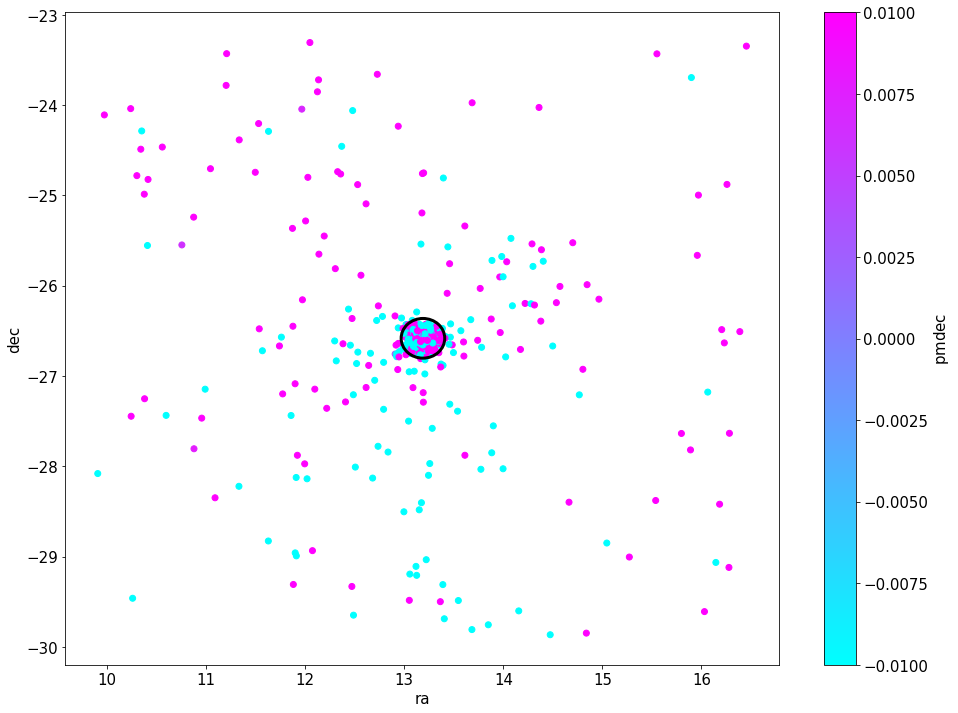

1711 1711
(1711,)
(224, 1)
(224, 1)
[0.    0.006 0.012 0.018 0.024 0.03  0.036 0.042 0.048 0.054 0.06  0.066
 0.072 0.078 0.084 0.09  0.096]
(1711, 1)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:463: RuntimeWarning: invalid value encountered in log10

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:464: RuntimeWarning: invalid value encountered in log10

(224,)


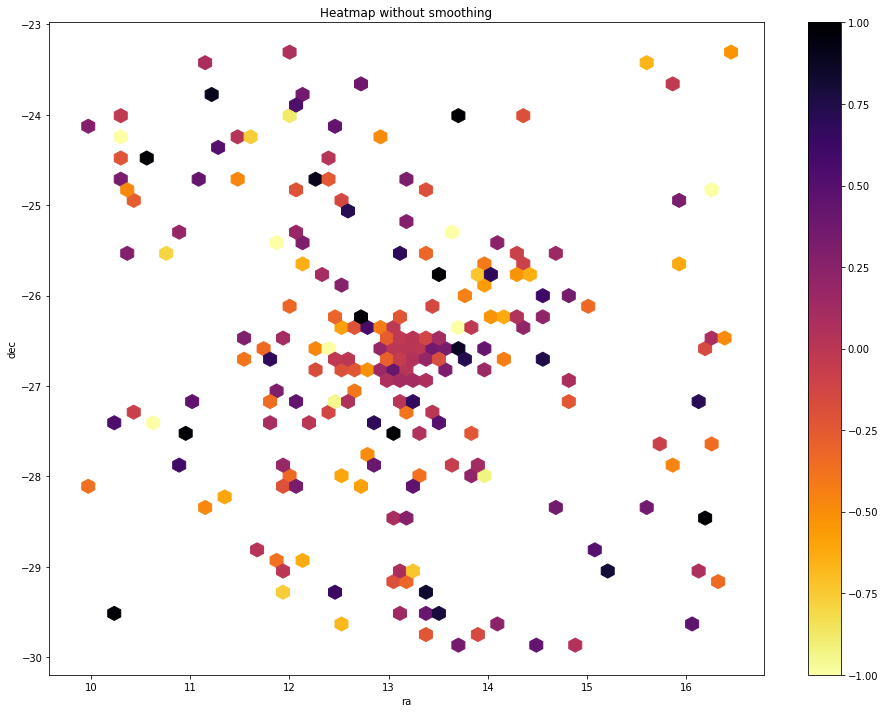

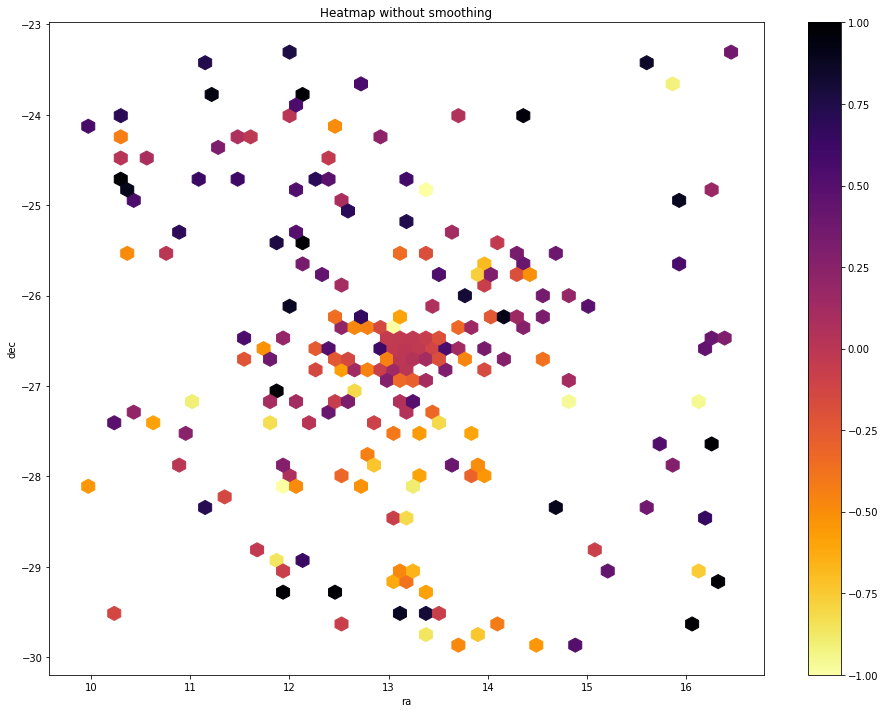

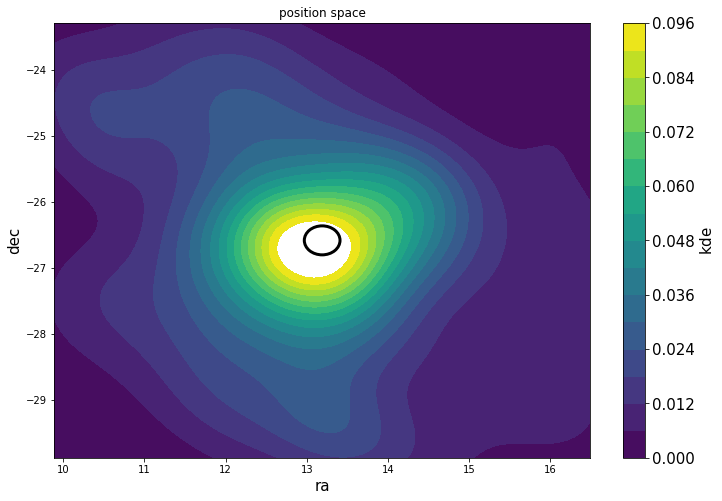

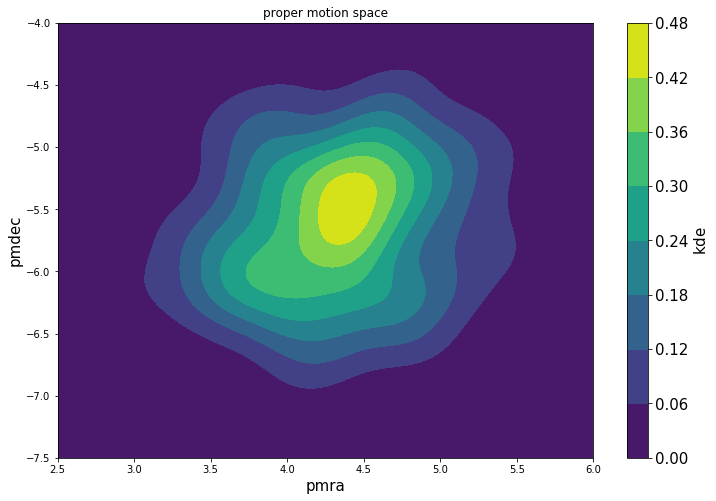

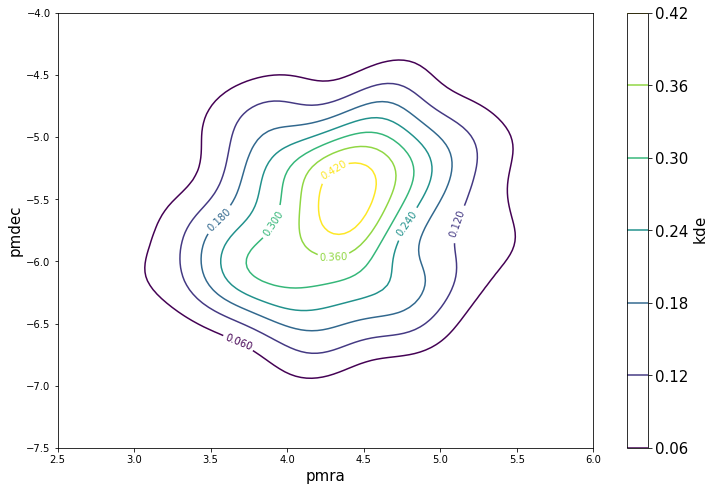

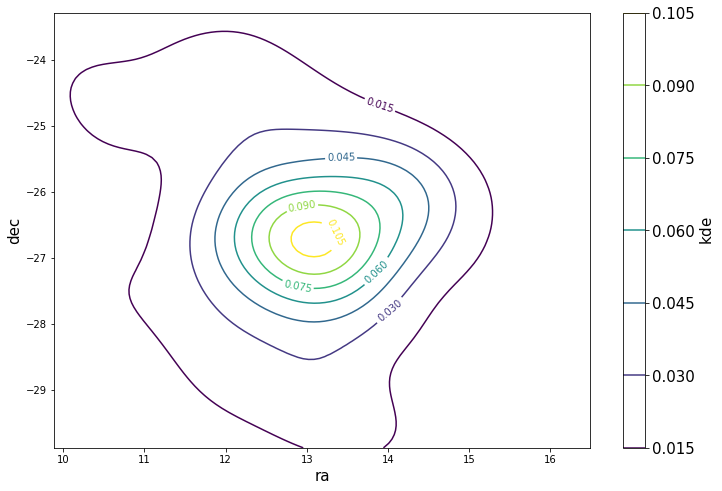

In [17]:
# DBSCAN !!

# Setup DBSCAN parameter input array
DB_Params =[]
#DB_Params=np.transpose(DB_Params) # This was needed for some reason

# index including parallax index for circle of stars outside tidal radius -> not used ..
#clust_edge2 = (np.sqrt((np.fabs(GlobClust_Log_ra_out[parallax_indx].as_matrix()-coord_ra_dec.ra.deg)**2+
#                        np.fabs(GlobClust_Log_dec_out[parallax_indx].as_matrix()-coord_ra_dec.dec.deg)**2))
#              >Tidal_Edge/60)

# index for all the cuts mentioned in the paper -> commented portion is the pm square cut for area of interest, but not needed
pm_indx=(GlobClust_Log_pmra_error[parallax_indx] < 1) * (GlobClust_Log_pmdec_error[parallax_indx] < 1) *\
        (GlobClust_Log_vpu[parallax_indx] > 8) * (GlobClust_Log_aen[parallax_indx] == 0) #*\
        #(GlobClust_Log_pmra[parallax_indx] > 2.5) * (GlobClust_Log_pmra[parallax_indx] < 6) *\
        #(GlobClust_Log_pmdec[parallax_indx] > -7.5) * (GlobClust_Log_pmdec[parallax_indx] < -3.5) #*\
        #(GlobClust_Log_M[parallax_indx] < 4.5) -> tested limiting , but never used
        
#plt.gca().set_ylim([-7.5, -4.5])
#plt.gca().set_xlim([2.5,6])

# set up epsilon and minimum samples for DBSCAN -> easier to change if needed
eps = 0.028
minsamp = 23

# DBSCAN DataFrame setup with scaled parameters 
# (scaled by observing histograms and for pms to be priortized, with CMD axes almost equal)
DF={'M': GlobClust_Log_M[parallax_indx][pm_indx]/7, 
    'rpbp': GlobClust_Log_rpbp[parallax_indx][pm_indx], 
    'pmra': GlobClust_Log_pmra[parallax_indx][pm_indx]/50, 'pmdec': GlobClust_Log_pmdec[parallax_indx][pm_indx]/50}
DB_Params = pd.DataFrame(data=DF)
print(shape(DB_Params)) 
DB_Params=DB_Params.dropna() # Must drop NaN's for DBSCAN to work
print(shape(DB_Params))      # Input star count


# Actual DBSCAN algorithm code
db=sklearn.cluster.DBSCAN(eps=eps, min_samples=minsamp, metric='euclidean', metric_params=None, algorithm='auto', 
                      leaf_size=30, p=None, n_jobs=1).fit(DB_Params) #original eps=0.1625

print(db.labels_) # shows noise vs data 
print(shape(db.labels_)) # DBSCAN output size

# DBSCAN output plotting setup -> plot o/p ontop of i/p
fig=plt.figure(figsize=(18,12))
plt.scatter(GlobClust_Log_rpbp[parallax_indx][pm_indx]/1, GlobClust_Log_M[parallax_indx][pm_indx]/7, 
            c=GlobClust_Log_rpbp[parallax_indx][pm_indx]/1, cmap='RdBu')   # i/p scaled as above

# This was taken straight from the online example for plotting
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of Subgroups: %d' % n_clusters_)

# Set up arrays for extracting DBSCAN data
x_param3=[]
y_param3=[]
x_param4=[]
y_param4=[]

# Taken from online example for plotting
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    
    #NOISE -> turn on to plot noise
    #xy = DB_Params[class_member_mask & ~core_samples_mask]
    #plt.plot(xy.loc[:, "rpbp"], xy.loc[:, "M"], 'o', markerfacecolor=tuple(col),
    #         markeredgecolor='k', markersize=6)
    
    #CLEANED DATA -> does not include boarder points
    xy = DB_Params[class_member_mask & core_samples_mask]
    
    plt.plot(xy.loc[:, "rpbp"], xy.loc[:, "M"], '.', markerfacecolor=tuple(col),)
     #       )#markeredgecolor='k')#, markersize=14)
    
    # Extract data and rescale
    x_param3.append(xy.loc[:, "rpbp"])
    y_param3.append(xy.loc[:, "M"]*7)

    # These can be used too but better code later
    #x_param4.append(xy.loc[:, "pmra"]*0.35)
    #y_param4.append(xy.loc[:, "pmdec"]*0.3)
    #x_param5.append(xy.loc[:, "ra"]*0.35)
    #y_param5.append(xy.loc[:, "dec"]*0.3)

# finish plot format, etc.
plt.gca().invert_yaxis()
plt.title('Estimated number of Subgroups: %d' % n_clusters_)
#cb=plt.colorbar()
#cb.ax.tick_params(labelsize=15)
plt.xlabel('bp-rp', fontsize=15)
plt.ylabel('M', fontsize=15)
plt.legend()
plt.show()
#fig.savefig('GC_DBSCAN'+ GlobClust_Log_ID[0] +'eps0p165-mins10_coreCMD-fullsetiponfullcmd.png') -> way to save plot with variable name

# Using extracted saved DBSCAN results data to get results of the other variables:
# First, convert to DataFrames without duplicated columns (x='rpbp', y='M')
x_out3 = pd.DataFrame(x_param3)
x_out3 = x_out3.transpose() 
x_out3 = x_out3.loc[:,~x_out3.columns.duplicated()]
#x_out3 -> print for testing 
y_out3 = pd.DataFrame(y_param3)
y_out3 = y_out3.transpose() 
y_out3 = y_out3.loc[:,~y_out3.columns.duplicated()]
print(shape(y_out3)) # DBSCAN results star count

# First need convert original Series variables to DataFrames
GC_ra = pd.DataFrame({'ra':GlobClust_Log_ra})
GC_dec = pd.DataFrame({'dec':GlobClust_Log_dec})
GC_pmra = pd.DataFrame({'pmra':GlobClust_Log_pmra})
GC_pmdec = pd.DataFrame({'pmdec':GlobClust_Log_pmdec})
GC_pmra_error = pd.DataFrame({'pmra_error':GlobClust_Log_pmra_error})
GC_pmdec_error = pd.DataFrame({'pmdec_error':GlobClust_Log_pmdec_error})

# Now reindex variables with DBSCAN output variables
# These are the variables used needed for the rest of the notebook !!
ra_DB = GC_ra.reindex(x_out3.index)
dec_DB = GC_dec.reindex(y_out3.index)
pmra_DB = GC_pmra.reindex(x_out3.index)
pmdec_DB = GC_pmdec.reindex(y_out3.index)
pmra_DB_error = GC_pmra_error.reindex(x_out3.index)
pmdec_DB_error = GC_pmdec_error.reindex(y_out3.index)
M_DB = GlobClust_Log_M.reindex(y_out3.index)
rpbp_DB = GlobClust_Log_rpbp.reindex(y_out3.index)

# Setup & print normalized DBSCAN pm's
pmra_DB_norm = (pmra_DB-pmra_DB.mean())#/(pmra_DB.mean())
pmdec_DB_norm = (pmdec_DB-pmdec_DB.mean())#/(pmdec_DB.mean())
print('\n', pmra_DB.mean(), '\n')
print('\n', pmdec_DB.mean())


# Multitude of plots for quick review!!
# PLOTS:
# 1. DBSCAN raw output over cut input (RdBu, all cuts) -> colourful; actually coded above variable definitions
# 2. Repeat of 1. w/ single colour for o/p (purple)
# 3. ra-dec o/p (purple) over i/p (cyan, only parallax cut)
# 4. pm's o/p (purple) over i/p (cyan, only parallax cut)
# 5. pm's o/p (purple) over i/p (cyan, all cuts) -> will show pm square cut if included above
# 6. ra-dec of results without stars inside tidal radius -> can see square doughnut from Piatti !
# 7. ra-dec of results coloured by pmra (inferno_r)
# 8. ra-dec of results coloured by pmdec (inferno_r) -> shows chosen eps, minsamps, pm fractional error in legend
# 9. ra-dec of results coloured by pmdec (cool; to see trend better, used in picking DBSCAN eps/minsamps)
# 10. ra-dec hexbins of results coloured by pmra (inferno_r)
# 11. ra-dec hexbins of results coloured by pmdec (inferno_r)
# 12. KDE filled contour of ra-dec results
# 12. KDE filled contour of pm results
# 12. KDE unfilled contour of pm results
# 12. KDE unfilled contour of ra-dec results

fig=plt.figure(figsize=(16,12))
plt.scatter(x=GlobClust_Log_rpbp[parallax_indx][pm_indx], y=GlobClust_Log_M[parallax_indx][pm_indx], 
            c=GlobClust_Log_rpbp[parallax_indx][pm_indx], cmap='RdBu', marker='.')
plt.scatter(x=rpbp_DB, y=M_DB, c='purple', alpha=0.7, marker='.')
#plt.scatter(x=rpbp_ic, y=M_ic, c='g', alpha=0.2, marker='.')
plt.xlabel('bp-rp', fontsize=15)
plt.ylabel('M', fontsize=15)
#plt.gca().invert_yaxis()
#plt.title('CMD of ' + GC_IDs[i], fontsize=15)
#cb=plt.colorbar()
#cb.ax.tick_params(labelsize=15)
#cb.set_label(r'$\mathrm{pmdec}$',fontsize=15)
plt.gca().tick_params(labelsize=15)
plt.gca().invert_yaxis()
plt.title('1. ')
plt.show()

fig=plt.figure(figsize=(16,12))
plt.scatter(x=GlobClust_Log_ra[parallax_indx], y=GlobClust_Log_dec[parallax_indx], c='c', alpha=0.3, marker='.')
#plt.scatter(x=rpbp_final2, y=M_final2, c='purple', alpha=0.7)
plt.scatter(x=ra_DB, y=dec_DB, c='purple', marker='.')#, alpha=0.2)
plt.xlabel('ra', fontsize=15)
plt.ylabel('dec', fontsize=15)
#plt.gca().invert_yaxis()
#plt.title('CMD of ' + GC_IDs[i], fontsize=15)
#cb=plt.colorbar()
#cb.ax.tick_params(labelsize=15)
#cb.set_label(r'$\mathrm{pmdec}$',fontsize=15)
plt.gca().tick_params(labelsize=15)
plt.show()

fig=plt.figure(figsize=(16,12))
#plt.hexbin(GlobClust_Log_pmdec_out, GlobClust_Log_pmra_out, extent=[-10,10, -10,10], bins='log',gridsize=200)
plt.scatter(x=GlobClust_Log_pmra[parallax_indx], y=GlobClust_Log_pmdec[parallax_indx], c='c', alpha=0.3, marker='.')
#plt.scatter(x=rpbp_final2, y=M_final2, c='purple', alpha=0.7)
plt.scatter(y=pmdec_DB, x=pmra_DB, c='purple', marker='.')#, alpha=0.2)
plt.xlabel('pmra', fontsize=15)
plt.ylabel('pmdec', fontsize=15)
#plt.gca().invert_yaxis()
#plt.title('CMD of ' + GC_IDs[i], fontsize=15)
#cb=plt.colorbar()
#cb.ax.tick_params(labelsize=15)
#cb.set_label(r'$\mathrm{pmdec}$',fontsize=15)
plt.gca().tick_params(labelsize=15)
#plt.gca().set_ylim([-7.5, -4.5])
#plt.gca().set_xlim([2.5,6])
plt.gca().set_ylim([-10,10])
plt.gca().set_xlim([-10,10])
#plt.gca().set_ylim([3.2, 4.7])
#plt.gca().set_xlim([-7.5,-3])
plt.show()

fig=plt.figure(figsize=(16,12))
#plt.hexbin(GlobClust_Log_pmdec_out, GlobClust_Log_pmra_out, extent=[-10,10, -10,10], bins='log',gridsize=200)
plt.scatter(x=GlobClust_Log_pmra[parallax_indx][pm_indx] , y=GlobClust_Log_pmdec[parallax_indx][pm_indx], c='c', alpha=0.3, marker='.')
#plt.scatter(x=rpbp_final2, y=M_final2, c='purple', alpha=0.7)
plt.scatter(y=pmdec_DB, x=pmra_DB, c='purple', marker='.')#, alpha=0.2)
plt.xlabel('pmra', fontsize=15)
plt.ylabel('pmdec', fontsize=15)
#plt.gca().invert_yaxis()
#plt.title('CMD of ' + GC_IDs[i], fontsize=15)
#cb=plt.colorbar()
#cb.ax.tick_params(labelsize=15)
#cb.set_label(r'$\mathrm{pmdec}$',fontsize=15)
plt.gca().tick_params(labelsize=15)
#plt.gca().set_ylim([-7.5, -4.5])
#plt.gca().set_xlim([2.5,6])
plt.gca().set_ylim([-10,10])
plt.gca().set_xlim([-10,10])
#plt.gca().set_ylim([3.2, 4.7])
#plt.gca().set_xlim([-7.5,-3])
plt.show()

# index for plot of results without stars inside tidal radius for next plot
clust_indx = (np.sqrt((np.fabs(ra_DB.as_matrix()-coord_ra_dec.ra.deg)**2+np.fabs(dec_DB.as_matrix()-coord_ra_dec.dec.deg)**2))
              >Tidal_Edge/60)

fig=plt.figure(figsize=(14,14))
ax = plt.gca()
#plt.scatter(x=GlobClust_Log_pmra_out, y=GlobClust_Log_pmdec_out, c='c', alpha=0.3, marker='.')
#plt.scatter(x=rpbp_final2, y=M_final2, c='purple', alpha=0.7)
plt.scatter(x=ra_DB[clust_indx]-coord_ra_dec.ra.deg, y=dec_DB[clust_indx]-coord_ra_dec.dec.deg, c='purple', marker='.')#, alpha=0.2)
plt.xlabel('ra', fontsize=15)
plt.ylabel('dec', fontsize=15)
circle = plt.Circle((0,0), GlobClust_Log_r_t/60*4, color='b', fill=False, lw=2)
#ax.add_artist(circle)
circle2 = plt.Circle((0,0), GlobClust_Log_r_t[0]/60, color='k', fill=False, lw=1)
ax.add_artist(circle2)
circle3 = plt.Circle((0,0), 5/60, color='pink', fill=False, lw=2)
#ax.add_artist(circle3)
#plt.gca().invert_yaxis()
#plt.title('CMD of ' + GC_IDs[i], fontsize=15)
#cb=plt.colorbar()
#cb.ax.tick_params(labelsize=15)
#cb.set_label(r'$\mathrm{pmdec}$',fontsize=15)
plt.gca().set_ylim([-2, 2])
plt.gca().set_xlim([-2,2])
plt.gca().tick_params(labelsize=15)
plt.show()

fig=plt.figure(figsize=(16,12))
ax = plt.gca()
#plt.scatter(x=GlobClust_Log_ra_out, y=GlobClust_Log_dec_out, c='c', alpha=0.3, marker='.')
#plt.scatter(x=rpbp_final2, y=M_final2, c='purple', alpha=0.7)
plt.scatter(x=ra_DB, y=dec_DB, c=pmra_DB_norm, cmap='inferno_r', marker='o', s=100)#, vmin=-1, vmax=1)#, alpha=0.2)
#plt.scatter(x=ra_DB, y=dec_DB, c=pmdec_DB_norm, cmap='inferno', marker='.', vmin=-1, vmax=1)#, alpha=0.2)
circle = plt.Circle((coord_ra_dec.ra.deg, coord_ra_dec.dec.deg), GlobClust_Log_r_t/60*4, color='b', fill=False, lw=5)
#ax.add_artist(circle)
circle2 = plt.Circle((coord_ra_dec.ra.deg, coord_ra_dec.dec.deg), GlobClust_Log_r_t[0]/60, color='k', fill=False, lw=3)
ax.add_artist(circle2)
circle3 = plt.Circle((coord_ra_dec.ra.deg, coord_ra_dec.dec.deg), 5/60, color='pink', fill=False, lw=2)
#ax.add_artist(circle3)
plt.xlabel('ra', fontsize=15)
plt.ylabel('dec', fontsize=15)
#plt.gca().invert_yaxis()
#plt.title('CMD of ' + GC_IDs[i], fontsize=15)
cb=plt.colorbar()
cb.ax.tick_params(labelsize=15)
cb.set_label(r'$\mathrm{pmra}$',fontsize=15)
plt.gca().tick_params(labelsize=15)
plt.show()

fig=plt.figure(figsize=(16,12))
ax = plt.gca()
#plt.scatter(x=GlobClust_Log_ra_out, y=GlobClust_Log_dec_out, c='c', alpha=0.3, marker='.')
#plt.scatter(x=rpbp_final2, y=M_final2, c='purple', alpha=0.7)
plt.scatter(x=ra_DB, y=dec_DB, c=pmdec_DB_norm, cmap='inferno_r', marker='o', s=100, 
            label='eps= %.3f, minsamp= %d, error < 1' %(eps, minsamp), vmin=-1, vmax=1)#vmin=-0.1, vmax=.1)#, alpha=0.2)
circle = plt.Circle((coord_ra_dec.ra.deg, coord_ra_dec.dec.deg), GlobClust_Log_r_t/60*4, color='b', fill=False, lw=5)
#ax.add_artist(circle)
circle2 = plt.Circle((coord_ra_dec.ra.deg, coord_ra_dec.dec.deg), GlobClust_Log_r_t[0]/60, color='k', fill=False, lw=3)
ax.add_artist(circle2)
circle3 = plt.Circle((coord_ra_dec.ra.deg, coord_ra_dec.dec.deg), 5/60, color='pink', fill=False, lw=2)
#ax.add_artist(circle3)
plt.xlabel('ra', fontsize=15)
plt.ylabel('dec', fontsize=15)
plt.legend()
#plt.gca().invert_yaxis()
#plt.title('CMD of ' + GC_IDs[i], fontsize=15)
cb=plt.colorbar()
cb.ax.tick_params(labelsize=15)
cb.set_label(r'$\mathrm{pmdec}$',fontsize=15)
plt.gca().tick_params(labelsize=15)
plt.show()

fig=plt.figure(figsize=(16,12))
ax = plt.gca()
#plt.scatter(x=GlobClust_Log_ra_out, y=GlobClust_Log_dec_out, c='c', alpha=0.3, marker='.')
#plt.scatter(x=rpbp_final2, y=M_final2, c='purple', alpha=0.7)
plt.scatter(x=ra_DB, y=dec_DB, c=pmdec_DB_norm, cmap='cool', marker='o', vmin=-0.01, vmax=0.01)#vmin=-0.1, vmax=.1)#, alpha=0.2)
circle = plt.Circle((coord_ra_dec.ra.deg, coord_ra_dec.dec.deg), GlobClust_Log_r_t/60*4, color='b', fill=False, lw=5)
#ax.add_artist(circle)
circle2 = plt.Circle((coord_ra_dec.ra.deg, coord_ra_dec.dec.deg), GlobClust_Log_r_t[0]/60, color='k', fill=False, lw=3)
ax.add_artist(circle2)
circle3 = plt.Circle((coord_ra_dec.ra.deg, coord_ra_dec.dec.deg), 5/60, color='pink', fill=False, lw=2)
#ax.add_artist(circle3)
plt.xlabel('ra', fontsize=15)
plt.ylabel('dec', fontsize=15)
#plt.gca().invert_yaxis()
#plt.title('CMD of ' + GC_IDs[i], fontsize=15)
cb=plt.colorbar()
cb.ax.tick_params(labelsize=15)
cb.set_label(r'$\mathrm{pmdec}$',fontsize=15)
plt.gca().tick_params(labelsize=15)
plt.show()

# for hexbin plots, removing NaN's
x=ra_DB[~numpy.isnan(ra_DB)]
y=dec_DB[~numpy.isnan(dec_DB)]
x=np.array(x)
y=np.array(y)
print(len(x),len(y))
print(x[:,0].shape)

fig=plt.figure(figsize=(16,12))
plt.hexbin(x[:,0], y[:,0], C=pmra_DB_norm, cmap='inferno_r', gridsize=50,vmin=-1,vmax=1)#, extent=[11,17,  -23,-29])
plt.colorbar()
plt.title('Heatmap without smoothing')
plt.ylabel("dec")
plt.xlabel("ra")

fig=plt.figure(figsize=(16,12))
plt.hexbin(x[:,0], y[:,0], C=pmdec_DB_norm, cmap='inferno_r', gridsize=50,vmin=-1,vmax=1)#, extent=[11,17,  -23,-29])
plt.colorbar()
plt.title('Heatmap without smoothing')
plt.ylabel("dec")
plt.xlabel("ra")


# KDE:
# Convert data to numpy arrays without stars inside tidal radius, print sizes
pmra_kde=pmra_DB[clust_indx].as_matrix()
pmdec_kde=pmdec_DB[clust_indx].as_matrix()
print(shape(pmdec_kde))
# same as above for ra-dec
ra_kde=ra_DB[clust_indx].as_matrix()
dec_kde=dec_DB[clust_indx].as_matrix()
print(shape(pmdec_kde))

# set pm limits for kde
pmra_kde_1 = 0-10 
pmra_kde_2 = 0+10
pmdec_kde_1 = 0-10
pmdec_kde_2 = 0+10

# indx for only finite values of data within limits set above
findx=(np.isfinite(pmra_kde))*(np.isfinite(pmdec_kde))*(pmra_kde<pmra_kde_2)*(pmra_kde>pmra_kde_1)*(pmdec_kde>pmdec_kde_1)*(pmdec_kde<pmdec_kde_2)

# Redefine r_t for ease of use
r_t = GlobClust_Log_r_t.as_matrix()
r_t = r_t[0]

# set ra-dec limits for kde 
ra_kde_1 = coord_ra_dec.ra.deg-r_t/60*15
ra_kde_2 = coord_ra_dec.ra.deg+r_t/60*15
dec_kde_1 = coord_ra_dec.dec.deg-r_t/60*15
dec_kde_2 = coord_ra_dec.dec.deg+r_t/60*15

#KDE part -> ra-dec
k = stats.gaussian_kde([ra_kde[findx], dec_kde[findx]], )
xi, yi = np.mgrid[ra_kde_1:ra_kde_2:100*1j, 
                  dec_kde_1:dec_kde_2:100*1j]
#xi, yi = np.mgrid[12:14:100*1j, 
#                  -28:-26:100*1j]
#print(xi,yi,k)
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
zii=zi.reshape(xi.shape)

contours = np.arange(0,0.1, 0.006)
print(contours)

# Plot KDE results
fig=plt.figure(figsize=(12,8))
ax=plt.gca()
plt.contourf(xi, yi, zii , levels=contours)#[0,0.025,0.05,0.075,0.1])# locator=ticker.LogLocator())
circle2 = plt.Circle((coord_ra_dec.ra.deg, coord_ra_dec.dec.deg), GlobClust_Log_r_t[0]/60, color='k', fill=False, lw=3)
ax.add_artist(circle2)
plt.title('position space')
plt.xlabel('ra', fontsize=15)
plt.ylabel('dec', fontsize=15)
cb=plt.colorbar()
cb.ax.tick_params(labelsize=15)
cb.set_label(r'$\mathrm{kde}$',fontsize=15)

#KDE part - pm's
k = stats.gaussian_kde([pmra_kde[findx], pmdec_kde[findx]], )
xi, yi = np.mgrid[2.5:6:100*1j, 
                  -7.5:-4:100*1j]
#print(xi,yi,k)
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
zii=zi.reshape(xi.shape)

# Plot pm kde as contours
fig=plt.figure(figsize=(12,8))
plt.contourf(xi, yi, zii ,)# locator=ticker.LogLocator())
plt.title('proper motion space')
plt.xlabel('pmra', fontsize=15)
plt.ylabel('pmdec', fontsize=15)
cb=plt.colorbar()
cb.ax.tick_params(labelsize=15)
cb.set_label(r'$\mathrm{kde}$',fontsize=15)

# to redfine findx for later
pmra_kde=pmra_DB[clust_indx].as_matrix()
pmdec_kde=pmdec_DB[clust_indx].as_matrix()

print(shape(clust_indx)) # just to know

# redefine findx for next plots
findx=(np.isfinite(pmra_kde))*(np.isfinite(pmdec_kde))#*(pmra_kde<2.*np.pi)*(pmra_kde>0.)*(pmdec_kde>-1.)*(pmdec_kde<1.)

lev_exp = np.arange(np.floor(np.log10(pmra_DB_norm[~numpy.isnan(pmra_DB_norm)]).min()-1),
                    np.ceil(np.log10(pmra_DB_norm[~numpy.isnan(pmra_DB_norm)]).max()+1))
levs = np.power(10, lev_exp)

print(shape(pmra_kde[findx])) # just to know


#KDE part -> pm's
k = stats.gaussian_kde([pmra_kde[findx], pmdec_kde[findx]], )
xi, yi = np.mgrid[2.5:6:100*1j, 
                  -7.5:-4:100*1j]
#print(xi,yi,k)
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
zii=zi.reshape(xi.shape)

fig=plt.figure(figsize=(12,8))
CS=plt.contour(xi, yi, zii, )# levs, norm=colors.LogNorm())#locator=ticker.LogLocator())
plt.xlabel('pmra', fontsize=15)
plt.ylabel('pmdec', fontsize=15)
plt.clabel(CS, inline=1, fontsize=10, )
cb=plt.colorbar()
cb.ax.tick_params(labelsize=15)
cb.set_label(r'$\mathrm{kde}$',fontsize=15)

#KDE part -> ra-dec
k = stats.gaussian_kde([ra_kde[findx], dec_kde[findx]], )
xi, yi = np.mgrid[ra_kde_1:ra_kde_2:100*1j, 
                  dec_kde_1:dec_kde_2:100*1j]
#print(xi,yi,k)
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
zii=zi.reshape(xi.shape)

fig=plt.figure(figsize=(12,8))
CS=plt.contour(xi, yi, zii )#, levs, norm=colors.LogNorm())#locator=ticker.LogLocator())
plt.xlabel('ra', fontsize=15)
plt.ylabel('dec', fontsize=15)
plt.clabel(CS, inline=1, fontsize=10, )
cb=plt.colorbar()
cb.ax.tick_params(labelsize=15)
cb.set_label(r'$\mathrm{kde}$',fontsize=15)

In [20]:
# concise star count check
print(shape(GlobClust_Log_M[parallax_indx][pm_indx]))
print(shape(DB_Params))
print(shape(M_DB))

(23540,)
(23224, 4)
(1711,)


#### Plots for Paper

In [24]:
# index for simulation to match square Gaia query -> needed for ra-dec plot
tidal_indx_sq = (fabs(ra_n-coord_ra_dec.ra.deg-0.85) < r_t/60*15 ) *\
                (fabs(dec_n-coord_ra_dec.dec.deg-0.1) < r_t/60*15 ) 

/home/kaderali/.local/lib/python3.6/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))



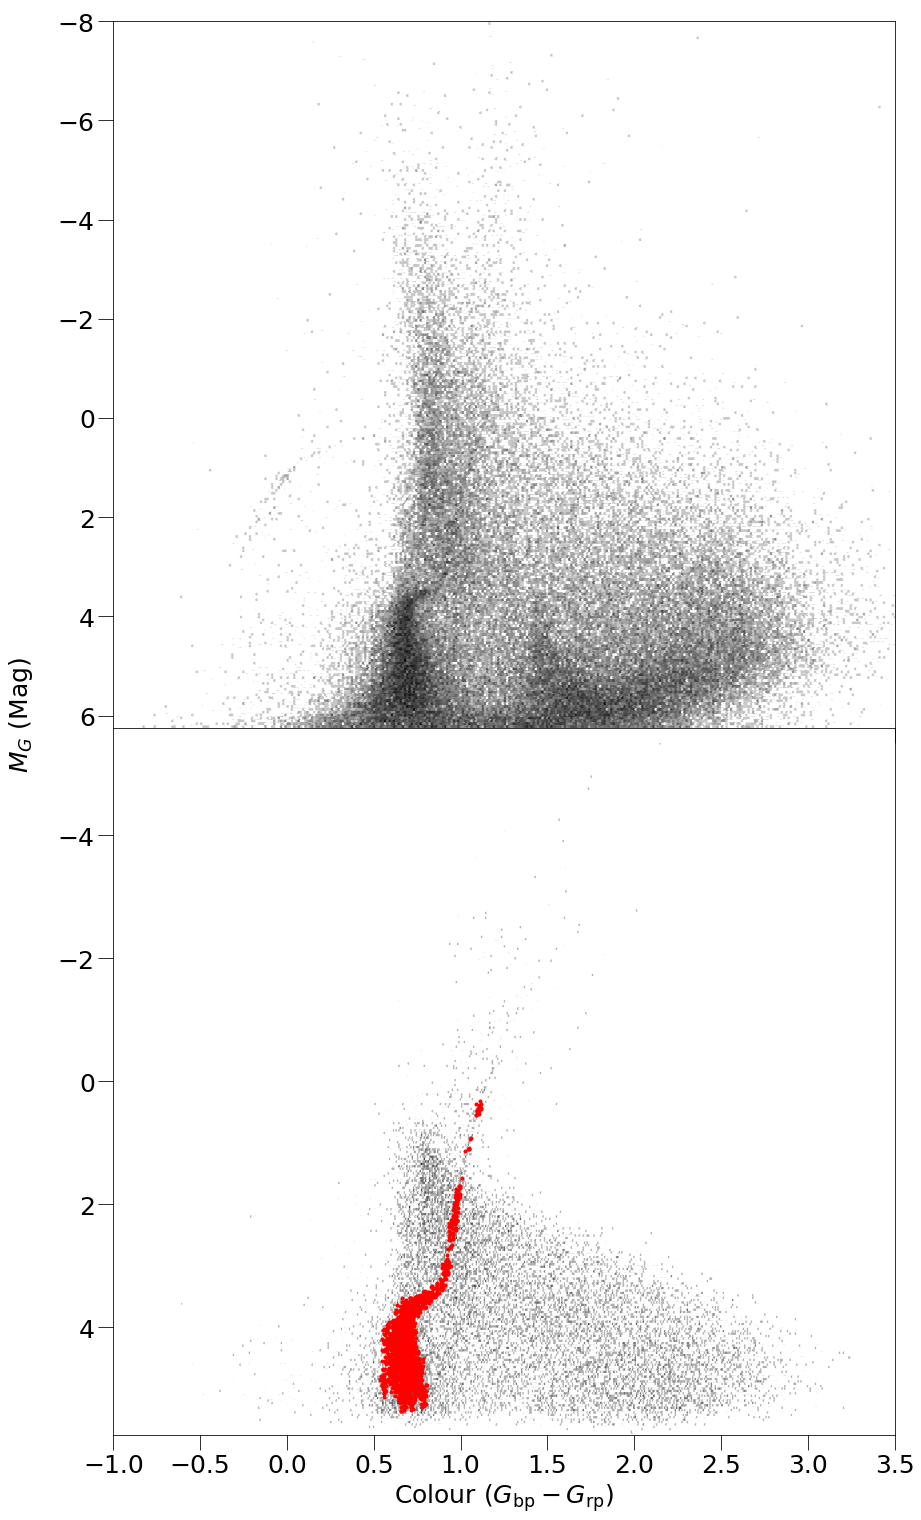

In [22]:
# CMD hexbin plots, all rasterized
f, ((ax1,ax2))=plt.subplots(2,1, sharex='col',figsize=(14,26))

jibbles=ax1.hexbin(x=GlobClust_Log_rpbp, y=GlobClust_Log_M, gridsize=500,bins='log',cmap='gist_yarg',  rasterized=True)#, extent=[-0.5,0.5,  0,2.5])
ax1.tick_params('both', labelsize=25, size=15)
ax1.set_xlim(-1,3.5)
ax1.set_ylim(-8,6.25)
ax1.invert_yaxis()

ax2.hexbin(x=GlobClust_Log_rpbp[parallax_indx][pm_indx], y=GlobClust_Log_M[parallax_indx][pm_indx], gridsize=500,bins='log',cmap='gist_yarg',  rasterized=True)
#ax2.scatter(x=GlobClust_Log_rpbp[parallax_indx][pm_indx], y=GlobClust_Log_M[parallax_indx][pm_indx], c='grey', marker='.')#, alpha=0.7, marker='.')
ax2.scatter(x=rpbp_DB, y=M_DB, c='red', marker='.',  rasterized=True)
ax2.tick_params('both', labelsize=25, size=15)
plt.subplots_adjust(hspace=0.)

plt.xlabel(r'$\mathrm{Colour}\ (G_{\mathrm{bp}}-G_{\mathrm{rp}}$)', fontsize=25)
plt.ylabel(r'$M_G\ (\mathrm{Mag})$', fontsize=25)
ax2.yaxis.set_label_coords(-0.1,1.02)
ax2.set_xlim(-1,3.5)
ax2.set_ylim(-5.75,5.75)
ax2.invert_yaxis()

#plt.savefig('NGC288_CMD_paper_2.pdf', bbox_inches='tight')


/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))



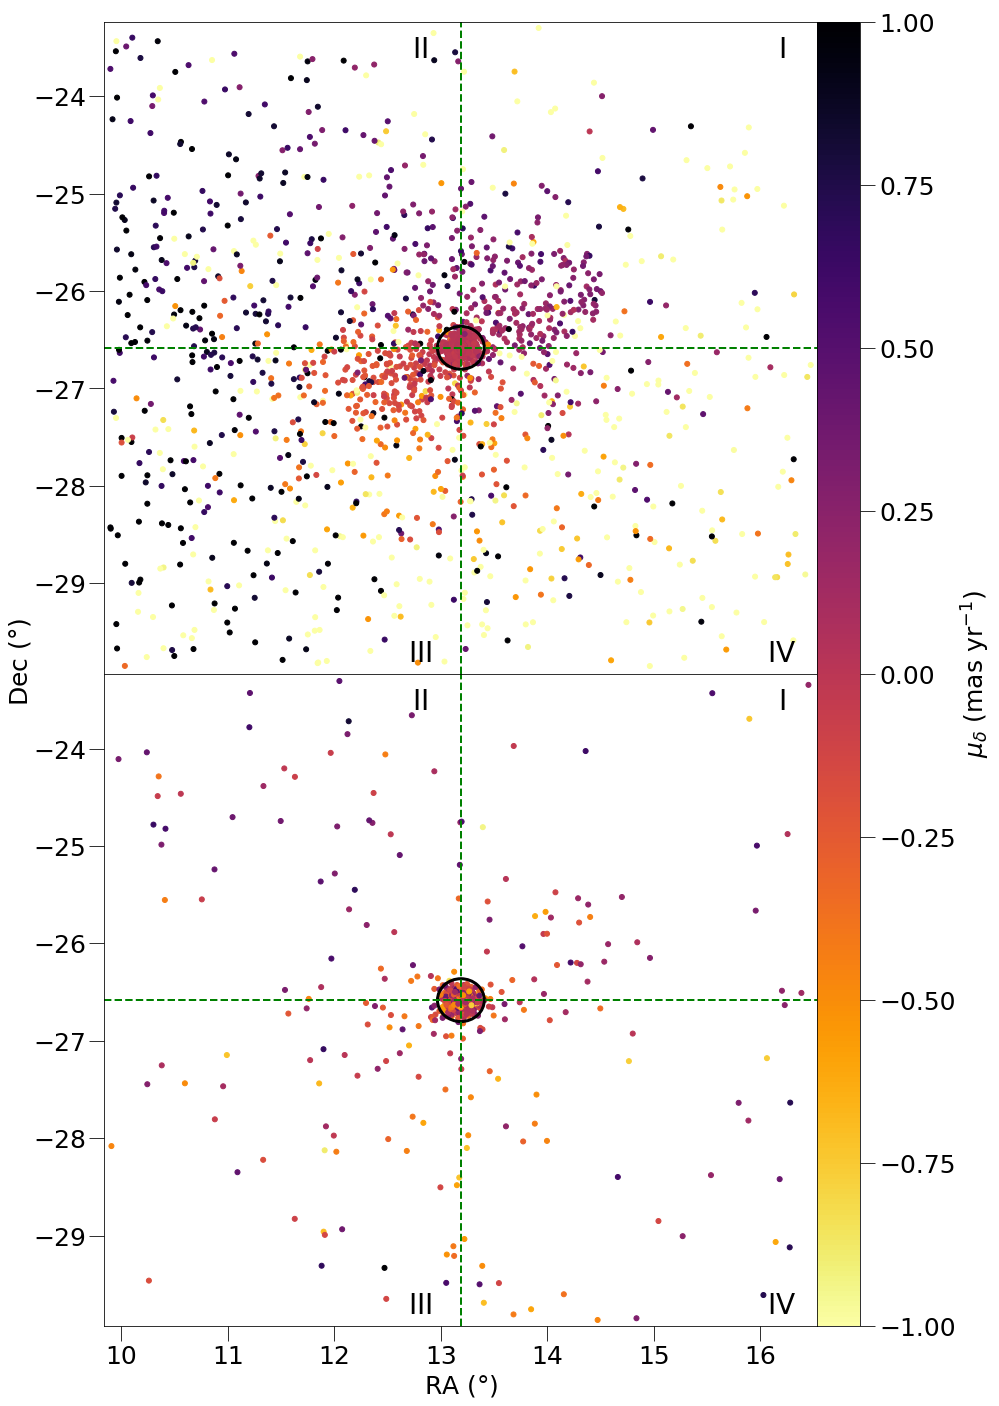

In [26]:
# RA-Dec pmdec coloured plots, simulation vs data, all rasterized

csfont = {'fontname':'Times New Roman'} #tried playing with font, didn't make a difference, used in one place

f, ((ax1,ax2))=plt.subplots(2,1, sharex='col',figsize=(12,24))
circle2 = plt.Circle((coord_ra_dec.ra.deg, coord_ra_dec.dec.deg), GlobClust_Log_r_t[0]/60, color='k', fill=False, lw=3)
jibbles=ax1.scatter(ra_n[tidal_indx_sq]-0.85, dec_n[tidal_indx_sq]-0.1, c=pmdec_n_norm[tidal_indx_sq], cmap='inferno_r',marker ='.',
            s=100, vmin=-1, vmax=1)
ax1.add_artist(circle2)
ax1.hlines(y=coord_ra_dec.dec.deg, xmin=coord_ra_dec.ra.deg-GlobClust_Log_r_t[0]/60*15-0.05, 
           xmax=coord_ra_dec.ra.deg+GlobClust_Log_r_t[0]/60*15+0.05, linewidth=2, color='g', linestyles='dashed')
ax1.vlines(x=coord_ra_dec.ra.deg, ymin=coord_ra_dec.dec.deg-GlobClust_Log_r_t[0]/60*15-0.05, 
           ymax=coord_ra_dec.dec.deg+GlobClust_Log_r_t[0]/60*15+0.05, linewidth=2, color='g', linestyles='dashed')
ax1.text(16.2, -23.6, r'$\mathrm{I}$', {'color': 'k', 'fontsize': 28}, **csfont, horizontalalignment='center')
ax1.text(12.8, -23.6, r'$\mathrm{II}$', {'color': 'k', 'fontsize': 28}, horizontalalignment='center')
ax1.text(12.8, -29.8, r'$\mathrm{III}$', {'color': 'k', 'fontsize': 28}, horizontalalignment='center')
ax1.text(16.2, -29.8, r'$\mathrm{IV}$', {'color': 'k', 'fontsize': 28}, horizontalalignment='center')
ax1.tick_params('both', labelsize=25, size=15)
ax1.set_xlim([coord_ra_dec.ra.deg - GlobClust_Log_r_t[0]/60*15-0.05, coord_ra_dec.ra.deg + GlobClust_Log_r_t[0]/60*15+0.05])
ax1.set_ylim([coord_ra_dec.dec.deg - GlobClust_Log_r_t[0]/60*15-0.05, coord_ra_dec.dec.deg + GlobClust_Log_r_t[0]/60*15+0.05])

ax2.scatter(x=ra_DB, y=dec_DB, c=pmdec_DB_norm, cmap='inferno_r', marker='.', s=100, 
            label='eps= %.3f, minsamp= %d, pmdec error < 1' %(eps, minsamp), )
circle2 = plt.Circle((coord_ra_dec.ra.deg, coord_ra_dec.dec.deg), GlobClust_Log_r_t[0]/60, color='k', fill=False, lw=3)
ax2.add_artist(circle2)
ax2.hlines(y=coord_ra_dec.dec.deg, xmin=coord_ra_dec.ra.deg-GlobClust_Log_r_t[0]/60*15-0.05, 
           xmax=coord_ra_dec.ra.deg+GlobClust_Log_r_t[0]/60*15+0.05, linewidth=2, color='g', linestyles='dashed')
ax2.vlines(x=coord_ra_dec.ra.deg, ymin=coord_ra_dec.dec.deg-GlobClust_Log_r_t[0]/60*15-0.05, 
           ymax=coord_ra_dec.dec.deg+GlobClust_Log_r_t[0]/60*15+0.05, linewidth=2, color='g', linestyles='dashed')
ax2.text(16.2, -23.6, r'$\mathrm{I}$', {'color': 'k', 'fontsize': 28}, **csfont, horizontalalignment='center')
ax2.text(12.8, -23.6, r'$\mathrm{II}$', {'color': 'k', 'fontsize': 28}, horizontalalignment='center')
ax2.text(12.8, -29.8, r'$\mathrm{III}$', {'color': 'k', 'fontsize': 28}, horizontalalignment='center')
ax2.text(16.2, -29.8, r'$\mathrm{IV}$', {'color': 'k', 'fontsize': 28}, horizontalalignment='center')
ax2.set_ylim([coord_ra_dec.dec.deg - GlobClust_Log_r_t[0]/60*15-0.05, coord_ra_dec.dec.deg + GlobClust_Log_r_t[0]/60*15+0.05])
ax2.tick_params('both', labelsize=25, size=15)
plt.subplots_adjust(hspace=0.)

plt.xlabel(r'$\mathrm{RA}\ (\mathrm{}{\degree}$)', fontsize=25) #\circ
plt.ylabel(r'$\mathrm{Dec}\ (\mathrm{}{\degree}$)', fontsize=25)
ax2.yaxis.set_label_coords(-0.1,1.02)

f.subplots_adjust(right=0.95)
cbar_ax=f.add_axes([0.95,0.125,0.05,0.755])
cb=f.colorbar(jibbles, cax=cbar_ax)
cb.ax.tick_params(labelsize=25, size=15)
cb.set_label(r'$\mu_{\delta}\ (\mathrm{mas\ yr}^{-1})$', fontsize=25)

#plt.savefig('NGC288_radec_paper.pdf', bbox_inches='tight')


In [30]:
# STATS ! -> KS 2 test

# index for square Gaia query windoe match in simulation without stars inside tidal radius
tidal_indx_sq2 = (fabs(ra_n-coord_ra_dec.ra.deg-0.85)<r_t/60*15) * (fabs(dec_n-coord_ra_dec.dec.deg-0.1)<r_t/60*15) *\
                 (np.sqrt((fabs(ra_n-coord_ra_dec.ra.deg-0.85))**2+(fabs(dec_n-coord_ra_dec.dec.deg-0.1))**2) > r_t/60)

# indexes simulation and DBSCAN to set quadrants
quad_I_n = ((ra_n[tidal_indx_sq2]-0.85) > coord_ra_dec.ra.deg[0]) *\
           ((dec_n[tidal_indx_sq2]-0.1) > coord_ra_dec.dec.deg[0])
    
quad_II_n = ((ra_n[tidal_indx_sq2]-0.85) < coord_ra_dec.ra.deg[0]) *\
            ((dec_n[tidal_indx_sq2]-0.1) > coord_ra_dec.dec.deg[0])
    
quad_III_n = ((ra_n[tidal_indx_sq2]-0.85) < coord_ra_dec.ra.deg[0]) *\
             ((dec_n[tidal_indx_sq2]-0.1) < coord_ra_dec.dec.deg[0])
    
quad_IV_n = ((ra_n[tidal_indx_sq2]-0.85) > coord_ra_dec.ra.deg[0]) *\
            ((dec_n[tidal_indx_sq2]-0.1) < coord_ra_dec.dec.deg[0])
    

quad_I_DB = ((ra_DB.as_matrix()[clust_indx]) > coord_ra_dec.ra.deg[0]) *\
            ((dec_DB.as_matrix()[clust_indx]) > coord_ra_dec.dec.deg[0])
    
quad_II_DB = ((ra_DB.as_matrix()[clust_indx]) < coord_ra_dec.ra.deg[0]) *\
             ((dec_DB.as_matrix()[clust_indx]) > coord_ra_dec.dec.deg[0])
    
quad_III_DB = ((ra_DB.as_matrix()[clust_indx]) < coord_ra_dec.ra.deg[0]) *\
              ((dec_DB.as_matrix()[clust_indx]) < coord_ra_dec.dec.deg[0])
    
quad_IV_DB = ((ra_DB.as_matrix()[clust_indx]) > coord_ra_dec.ra.deg[0]) *\
             ((dec_DB.as_matrix()[clust_indx]) < coord_ra_dec.dec.deg[0])

print('QI pmdec: \n', stats.ks_2samp(pmdec_n_norm[tidal_indx_sq2][quad_I_n], np.asarray(pmdec_DB_norm[clust_indx][quad_I_DB])[:,0]), '\n')
print('QII pmdec: \n', stats.ks_2samp(pmdec_n_norm[tidal_indx_sq2][quad_II_n], np.asarray(pmdec_DB_norm[clust_indx][quad_II_DB])[:,0]), '\n')
print('QIII pmdec: \n', stats.ks_2samp(pmdec_n_norm[tidal_indx_sq2][quad_III_n], np.asarray(pmdec_DB_norm[clust_indx][quad_III_DB])[:,0]), '\n')
print('QIV pmdec: \n', stats.ks_2samp(pmdec_n_norm[tidal_indx_sq2][quad_IV_n], np.asarray(pmdec_DB_norm[clust_indx][quad_IV_DB])[:,0]), '\n')


/home/kaderali/.local/lib/python3.6/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))

QI pmdec: 
 Ks_2sampResult(statistic=0.17660079051383398, pvalue=0.153463719221741) 

QII pmdec: 
 Ks_2sampResult(statistic=0.16585417549809245, pvalue=0.12827445637630625) 

QIII pmdec: 
 Ks_2sampResult(statistic=0.16123188405797095, pvalue=0.07638962349588996) 

QIV pmdec: 
 Ks_2sampResult(statistic=0.33707865168539325, pvalue=5.6973781595830834e-05) 



QI pmdec: 
 Ks_2sampResult(statistic=0.27499999999999997, pvalue=0.07960393196164639) 

QII pmdec: 
 Ks_2sampResult(statistic=0.25, pvalue=0.1392522339398094) 

QIII pmdec: 
 Ks_2sampResult(statistic=0.375, pvalue=0.0049842245287430075) 

QIV pmdec: 
 Ks_2sampResult(statistic=0.42500000000000004, pvalue=0.0009058696820068922) 

(267,) (53,)
QI pmdec: 
 Ks_2sampResult(statistic=0.17660079051383398, pvalue=0.153463719221741) 

QII pmdec: 
 Ks_2sampResult(statistic=0.16585417549809245, pvalue=0.12827445637630625) 

QIII pmdec: 
 Ks_2sampResult(statistic=0.16123188405797095, pvalue=0.07638962349588996) 

QIV pmdec: 
 Ks_2sampResult(statistic=0.33707865168539325, pvalue=5.6973781595830834e-05) 

Dec 

QI dec: 
 Ks_2sampResult(statistic=0.18814229249011857, pvalue=0.10855632662544079) 

QII dec: 
 Ks_2sampResult(statistic=0.23585205595591352, pvalue=0.007744381541861165) 

QIII dec: 
 Ks_2sampResult(statistic=0.10257073844030373, pvalue=0.5234178892002546) 

QIV dec: 
 Ks_2sampResult(statist

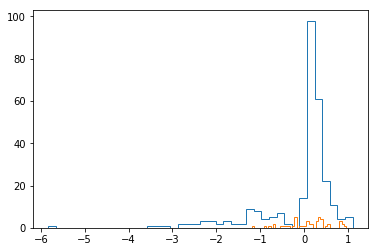

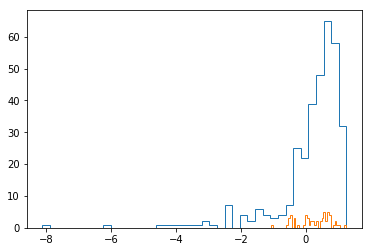

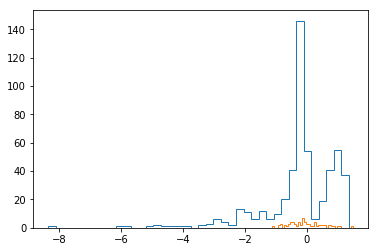

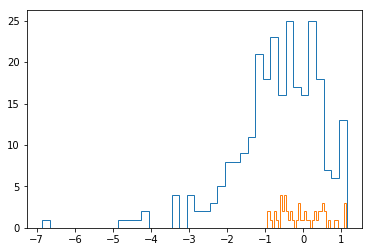

In [29]:
#Other stats infor and stuff tried:

# plot histograms per quandrant
nbins=40
#QUAD I
plt.figure()
QI_c_pmdec_n, ed, pat = plt.hist(x=pmdec_n_norm[tidal_indx_sq2][quad_I_n], bins=nbins, histtype='step')
QI_c_pmdec_DB, ed, pat = plt.hist(x=pmdec_DB_norm[clust_indx][quad_I_DB].as_matrix(), bins=nbins, histtype='step')

#QUAD II
plt.figure()
QII_c_pmdec_n, ed, pat = plt.hist(x=pmdec_n_norm[tidal_indx_sq2][quad_II_n], bins=nbins, histtype='step')
QII_c_pmdec_DB, ed, pat = plt.hist(x=pmdec_DB_norm[clust_indx][quad_II_DB].as_matrix(), bins=nbins, histtype='step')

#QUAD III
plt.figure()
QIII_c_pmdec_n, ed, pat = plt.hist(x=pmdec_n_norm[tidal_indx_sq2][quad_III_n], bins=nbins, histtype='step')
QIII_c_pmdec_DB, ed, pat = plt.hist(x=pmdec_DB_norm[clust_indx][quad_III_DB].as_matrix(), bins=nbins, histtype='step')

#QUAD IV
plt.figure()
QIV_c_pmdec_n, ed, pat = plt.hist(x=pmdec_n_norm[tidal_indx_sq2][quad_IV_n], bins=nbins, histtype='step')
QIV_c_pmdec_DB, ed, pat = plt.hist(x=pmdec_DB_norm[clust_indx][quad_IV_DB].as_matrix(), bins=nbins, histtype='step')

#QIV_c_pmdec_n = np.ones(QIV_c_pmdec_n.shape)
#QIV_c_pmdec_DB = np.ones(QIV_c_pmdec_DB.shape)

print('QI pmdec: \n', stats.ks_2samp(QI_c_pmdec_n, QI_c_pmdec_DB), '\n')
print('QII pmdec: \n', stats.ks_2samp(QII_c_pmdec_n, QII_c_pmdec_DB), '\n')
print('QIII pmdec: \n', stats.ks_2samp(QIII_c_pmdec_n, QIII_c_pmdec_DB), '\n')
print('QIV pmdec: \n', stats.ks_2samp(QIV_c_pmdec_n, QIV_c_pmdec_DB), '\n')

print(shape(pmdec_n_norm[tidal_indx_sq2][quad_IV_n]), shape(np.asarray(pmdec_DB_norm[clust_indx][quad_IV_DB])[:,0]))

print('QI pmdec: \n', stats.ks_2samp(pmdec_n_norm[tidal_indx_sq2][quad_I_n], np.asarray(pmdec_DB_norm[clust_indx][quad_I_DB])[:,0]), '\n')
print('QII pmdec: \n', stats.ks_2samp(pmdec_n_norm[tidal_indx_sq2][quad_II_n], np.asarray(pmdec_DB_norm[clust_indx][quad_II_DB])[:,0]), '\n')
print('QIII pmdec: \n', stats.ks_2samp(pmdec_n_norm[tidal_indx_sq2][quad_III_n], np.asarray(pmdec_DB_norm[clust_indx][quad_III_DB])[:,0]), '\n')
print('QIV pmdec: \n', stats.ks_2samp(pmdec_n_norm[tidal_indx_sq2][quad_IV_n], np.asarray(pmdec_DB_norm[clust_indx][quad_IV_DB])[:,0]), '\n')

print('Dec \n')
print('QI dec: \n', stats.ks_2samp(dec_n[tidal_indx_sq2][quad_I_n], np.asarray(dec_DB[clust_indx][quad_I_DB])[:,0]), '\n')
print('QII dec: \n', stats.ks_2samp(dec_n[tidal_indx_sq2][quad_II_n], np.asarray(dec_DB[clust_indx][quad_II_DB])[:,0]), '\n')
print('QIII dec: \n', stats.ks_2samp(dec_n[tidal_indx_sq2][quad_III_n], np.asarray(dec_DB[clust_indx][quad_III_DB])[:,0]), '\n')
print('QIV dec: \n', stats.ks_2samp(dec_n[tidal_indx_sq2][quad_IV_n], np.asarray(dec_DB[clust_indx][quad_IV_DB])[:,0]), '\n')

print('RA \n')
print('QI ra: \n', stats.ks_2samp(ra_n[tidal_indx_sq2][quad_I_n], np.asarray(ra_DB[clust_indx][quad_I_DB])[:,0]), '\n')
print('QII ra: \n', stats.ks_2samp(ra_n[tidal_indx_sq2][quad_II_n], np.asarray(ra_DB[clust_indx][quad_II_DB])[:,0]), '\n')
print('QIII ra: \n', stats.ks_2samp(ra_n[tidal_indx_sq2][quad_III_n], np.asarray(ra_DB[clust_indx][quad_III_DB])[:,0]), '\n')
print('QIV ra: \n', stats.ks_2samp(ra_n[tidal_indx_sq2][quad_IV_n], np.asarray(ra_DB[clust_indx][quad_IV_DB])[:,0]), '\n')


print('Full: \n', stats.ks_2samp(pmdec_n_norm, np.asarray(pmdec_DB_norm)[:,0]), '\n')

print('QI model:', np.sum(QI_c_pmdec_n))
print('QI data: ', np.sum(QI_c_pmdec_DB))
print('QII model: ', np.sum(QII_c_pmdec_n))
print('QII data: ', np.sum(QII_c_pmdec_DB))
print('QIII model: ', np.sum(QIII_c_pmdec_n))
print('QIII data: ', np.sum(QIII_c_pmdec_DB))
print('QIV model: ', np.sum(QIV_c_pmdec_n))
print('QIV data:', np.sum(QIV_c_pmdec_DB))

print('\n QI model:', len(pmdec_n_norm[tidal_indx_sq2][quad_I_n]))
print('QI data: ', len(pmdec_DB_norm[clust_indx][quad_I_DB]))
print('QII model: ', len(pmdec_n_norm[tidal_indx_sq2][quad_II_n]))
print('QII data: ', len(pmdec_DB_norm[clust_indx][quad_II_DB]))
print('QIII model: ', len(pmdec_n_norm[tidal_indx_sq2][quad_III_n]))
print('QIII data: ', len(pmdec_DB_norm[clust_indx][quad_III_DB]))
print('QIV model: ', len(pmdec_n_norm[tidal_indx_sq2][quad_IV_n]))
print('QIV data:', len(pmdec_DB_norm[clust_indx][quad_IV_DB]))

print(QII_c_pmdec_n, QII_c_pmdec_DB)
print(QIV_c_pmdec_n, QIV_c_pmdec_DB)

print(np.sum(QI_c_pmdec_n),np.sum(QII_c_pmdec_n),np.sum(QIII_c_pmdec_n),np.sum(QIV_c_pmdec_n))

